# Homework 2

-SUSHMA NIVENI PINDIGA

## 1. Setting up your Spark instance

In [ ]:
import pandas as pd

# Load data
df = pd.read_csv('2015-summary.csv')

# Show rows where the destination country is 'United States' in a dataframe
print(df[df['DEST_COUNTRY_NAME'] == 'United States'])

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .appName("FlightDataAnalysis")\
        .getOrCreate()

In [ ]:
Summary_data_2015 = spark.read\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .csv("/content/2015-summary.csv")

# Show the DataFrame
Summary_data_2015.show()


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# show the first five rows
Summary_data_2015.show(5)

In [ ]:
# Providing the execution plan after sorting the DataFrame 'Summary_data_2015' by the 'count' column
Summary_data_2015.sort("count").explain()


In [ ]:
# Setting the value to 5 to reduce the number of output partitions from the shuffle
spark.conf.set("spark.sql.shuffle.partitions", "5")

# Taking the first 2 rows after sorting the DataFrame by the 'count' column
Summary_data_2015.sort("count").take(2)


In [ ]:
# Creating a temporary view for the DataFrame 'Summary_data_2015'
Summary_data_2015.createOrReplaceTempView("Summary_data_2015_table")

# This allows querying the DataFrame using SQL syntax


In [ ]:
# SQL approach: Executing a SQL query to count flights per destination country
sqlWay = spark.sql("""
SELECT DEST_COUNTRY_NAME, count(1)
FROM Summary_data_2015
GROUP BY DEST_COUNTRY_NAME
""")

# DataFrame approach: Using DataFrame operations to count flights per destination country
dataFrameWay = Summary_data_2015\
    .groupBy("DEST_COUNTRY_NAME")\
    .count()

# Explaining the execution plan for both methods
print("SQL Execution Plan:")
sqlWay.explain()
print("\nDataFrame Execution Plan:")
dataFrameWay.explain()


In [ ]:
from pyspark.sql.functions import max

# SQL query to find the maximum 'count'
max_count_sql = spark.sql("SELECT max(count) as max_count FROM Summary_data_2015")
sql_result = max_count_sql.take(1)

# DataFrame operation to find the maximum 'count'
max_count_df = Summary_data_2015.select(max("count").alias("max_count"))
df_result = max_count_df.take(1)

# Displaying the results
print("Maximum count (SQL):", sql_result)
print("Maximum count (DataFrame):", df_result)


In [ ]:
from pyspark.sql import SparkSession

# Initializing SparkSession
spark = SparkSession.builder\
        .appName("DataFrames")\
        .getOrCreate()

# Executing an SQL query to find the top 5 destinations by flight count
top_destinations = spark.sql("""
SELECT DEST_COUNTRY_NAME, sum(count) AS destination_total
FROM Summary_data_2015
GROUP BY DEST_COUNTRY_NAME
ORDER BY sum(count) DESC
LIMIT 5
""")

# Displaying the top destinations
top_destinations.show()


In [ ]:
from pyspark.sql.functions import sum, desc

# Aggregating and retrieving the top 5 destination countries by flight count
dataFrameWay = Summary_data_2015 \
    .groupBy("DEST_COUNTRY_NAME") \
    .agg(sum("count").alias("destination_total")) \
    .orderBy(desc("destination_total")) \
    .limit(5)

# Displaying the results for validation
dataFrameWay.show()



# 2. Climate Change: Project Tasmania


On Canvas, you will find two datasets. The first dataset contains temperature
data by countries. Date starts from 1750 for average land temperature and goes
up to 2015. Answer the following questions:

### a. For which country and during what year, the highest average temperature was observed?

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, avg, col, max, min

# Creating a Spark session
spark = SparkSession.builder \
  .appName("Temperature Analysis") \
  .getOrCreate()

# Reading the data from the specified CSV file, inferring schema and using the first row as header
df = spark.read.csv("/content/GlobalLandTemperatures_GlobalLandTemperaturesByCountry.csv", header=True, inferSchema=True)


In [ ]:
# Assuming the date column is named 'dt' and the average temperature column is named 'AverageTemperature'
# Adding a new column 'Year' extracted from the 'dt' column and filtering out rows with null average temperature
df_year_filtered = df.withColumn("Year", year(col("dt"))).filter(col("AverageTemperature").isNotNull())


In [ ]:
# Grouping by country and year and then calculating the average temperature
avg_temp_by_country_year = df_year_filtered.groupBy("Country", "Year").agg(avg("AverageTemperature").alias("AverageTemperature"))


In [ ]:
# Ordering by average temperature in descending order
max_avg_temp_result = avg_temp_by_country_year.orderBy(col("AverageTemperature").desc()).first()


In [ ]:
# Showing the country and year with the highest average temperature
print(f"The country with the highest average temperature was {max_avg_temp_result['Country']} in the year {max_avg_temp_result['Year']}.")


### b. Analyze the data by country over the years, and name which are the top 10 countries with the biggest change in average temperature.

In [ ]:
# Finding the maximum and minimum average temperatures for each country
country_temp_stats_result = avg_temp_by_country_year.groupBy("Country") \
    .agg(max("AverageTemperature").alias("MaxTemperature"), min("AverageTemperature").alias("MinTemperature"))


In [ ]:
# Calculating the difference between max and min temperatures for each country
country_temp_change_result = country_temp_stats_result.withColumn("TemperatureChange", col("MaxTemperature") - col("MinTemperature"))


In [ ]:
# Ordering by the change in temperature and selecting only the top 10
top_countries_by_temp_change_result = country_temp_change_result \
    .select("Country", "TemperatureChange") \
    .orderBy(col("TemperatureChange").desc()) \
    .limit(10)

# Displaying the result
top_countries_by_temp_change_result.show()


The second dataset contains data on CO2 Emissions per capita across countries from 1960 to 2014.

### a. Merge the two datasets by country, and keep the data from 1960 to 2014.

In [ ]:
# Reading the global land temperatures data
temperature_df = spark.read.csv("/content/GlobalLandTemperatures_GlobalLandTemperaturesByCountry.csv", header=True, inferSchema=True)

# Reading the CO2 emissions data
emissions_df = spark.read.csv("/content/CO2 emissions per capita per country.csv", header=True, inferSchema=True)
emissions_df = emissions_df.withColumnRenamed("Country Name", "Country")


In [ ]:
from pyspark.sql.functions import col, explode, lit, struct, array

# Flatten the CO2 DataFrame from wide format to long format
years_list = list(map(str, range(1960, 2015)))  # Year columns as strings
co2_long_format_df = emissions_df.select(
    "Country",
    explode(array(*[
        struct(lit(year).alias("Year"), col(year).alias("CO2Emissions"))
        for year in years_list
    ])).alias("YearData")
).select(
    "Country",
    col("YearData.Year"),
    col("YearData.CO2Emissions")
)


In [ ]:
# Filter the temperature data to include years from 1960 to 2014
temperature_filtered_df = temperature_df.withColumn("Year", year("dt")) \
                                 .filter((col("Year") >= 1960) & (col("Year") <= 2014))

# Join the filtered temperature data with the CO2 emissions data
merged_data_df = temperature_filtered_df.join(co2_long_format_df, ["Country", "Year"])

# Display the result
merged_data_df.show(10)


### b. What is the correlation between CO2 emissions and temperature change?

In [ ]:
from pyspark.sql.functions import year, col, lag, corr
from pyspark.sql.window import Window
from pyspark.sql.functions import format_string

# Filter the temperature data to include years from 1960 to 2014
temperature_filtered_df = temperature_df.withColumn("Year", year("dt")) \
                                 .filter((col("Year") >= 1960) & (col("Year") <= 2014))

# Join the filtered temperature data with the CO2 emissions data
merged_data_df = temperature_filtered_df.join(co2_long_format_df, ["Country", "Year"])

# Create a window specification ordered by Year for each Country
window_specification = Window.partitionBy("Country").orderBy("Year")

# Calculate the annual change in temperature using the correct column name
merged_data_df = merged_data_df.withColumn("PreviousYearTemp", lag("AverageTemperature", 1).over(window_specification))
merged_data_df = merged_data_df.withColumn("TemperatureChange", col("AverageTemperature") - col("PreviousYearTemp"))

# Filter out rows where any of the required data is null to ensure correlation is correctly computed
cleaned_data_df = merged_data_df.filter(col("TemperatureChange").isNotNull() & col("CO2Emissions").isNotNull())

# Compute the correlation between CO2 emissions and temperature change
correlation_result = cleaned_data_df.select(corr("CO2Emissions", "TemperatureChange").alias("Correlation"))


# Compute the correlation between CO2 emissions and temperature change
correlation_result = cleaned_data_df.select(
    format_string("%.4f", corr("CO2Emissions", "TemperatureChange")).alias("Correlation")
)

# Display the correlation result
correlation_result.show()


### Run all the above on Google’s Colab. However, create a cluster in google cloud and run code as a spark job (this step will help  in your final project, will have to deal with big datasets that cannot just run on Google’s Colab).

In [ ]:
""" To run the code on Google Colab and create a cluster in Google Cloud, follow these steps:

### Google Colab:
1. Sign in to your Google account.
2. Open Google Colab (colab.research.google.com).
3. Upload the code to Google Colab.
4. Execute the code cells in Colab to ensure they run without errors.
5. Save the Colab notebook.

### Google Cloud Platform (GCP):
1. Activate Billing: Ensure billing is enabled for your GCP project.
2. Enable APIs: Enable the Cloud Dataproc API, Google Cloud Storage API, and Google Cloud Resource Manager API.
3. IAM & Admin: Grant necessary roles to your service account and personal account for accessing resources.
4. Cloud Storage: Create a new bucket to store input and output data.
5. Set Up Cluster:
   - Region: Choose 'us-west1'.
   - Enable advanced optimizations.
   - Choose default settings for primary network and subnetwork.
   - Enable component gateway.
   - Select Jupyter notebook and Zeppelin notebook.
6. Configure Nodes:
   - Choose machine type: n2-standard-2 for both primary and worker nodes.
   - Set primary disk size to 30 GB with standard persistent disk.
7. Customize Cluster:
   - Set cluster idle time to 2 hours.
8. Create Cluster: Click on "Create" to create the cluster.

### Running the Spark Job:
1. Upload your code and data files to the Cloud Storage bucket.
2. SSH into the master node of the created cluster.
3. Copy the code and data files from Cloud Storage to the master node.
4. Submit the Spark job using the `gcloud` command or by running a Spark-submit script.
5. Monitor the job progress using the Dataproc UI or command-line tools.
6. Once the job is completed, retrieve the output files from the Cloud Storage bucket.


I followed these steps to run the provided code on Google Colab for testing and then created a Dataproc cluster on Google Cloud Platform to run the code as a Spark job. Screenshots of the cluster creation process are attached below for reference.

This screenshot shows the configuration of the Dataproc cluster, including the choice of machine types, disk sizes, and other settings.

"I set up and tested the code on Google Colab before creating a Dataproc cluster on Google Cloud Platform.
After enabling necessary APIs and activating billing, I configured a Dataproc cluster in the 'us-west1' region with optimized settings.
The cluster utilized n2-standard-2 machines with 30 GB primary disks and auto-deletion after 2 hours of inactivity. Following cluster creation,
I uploaded the code and data to a Cloud Storage bucket and submitted the Spark job via `gcloud` command.
The job ran successfully,monitored through the Dataproc UI, and upon completion, retrieved output files from Cloud Storage."



"""

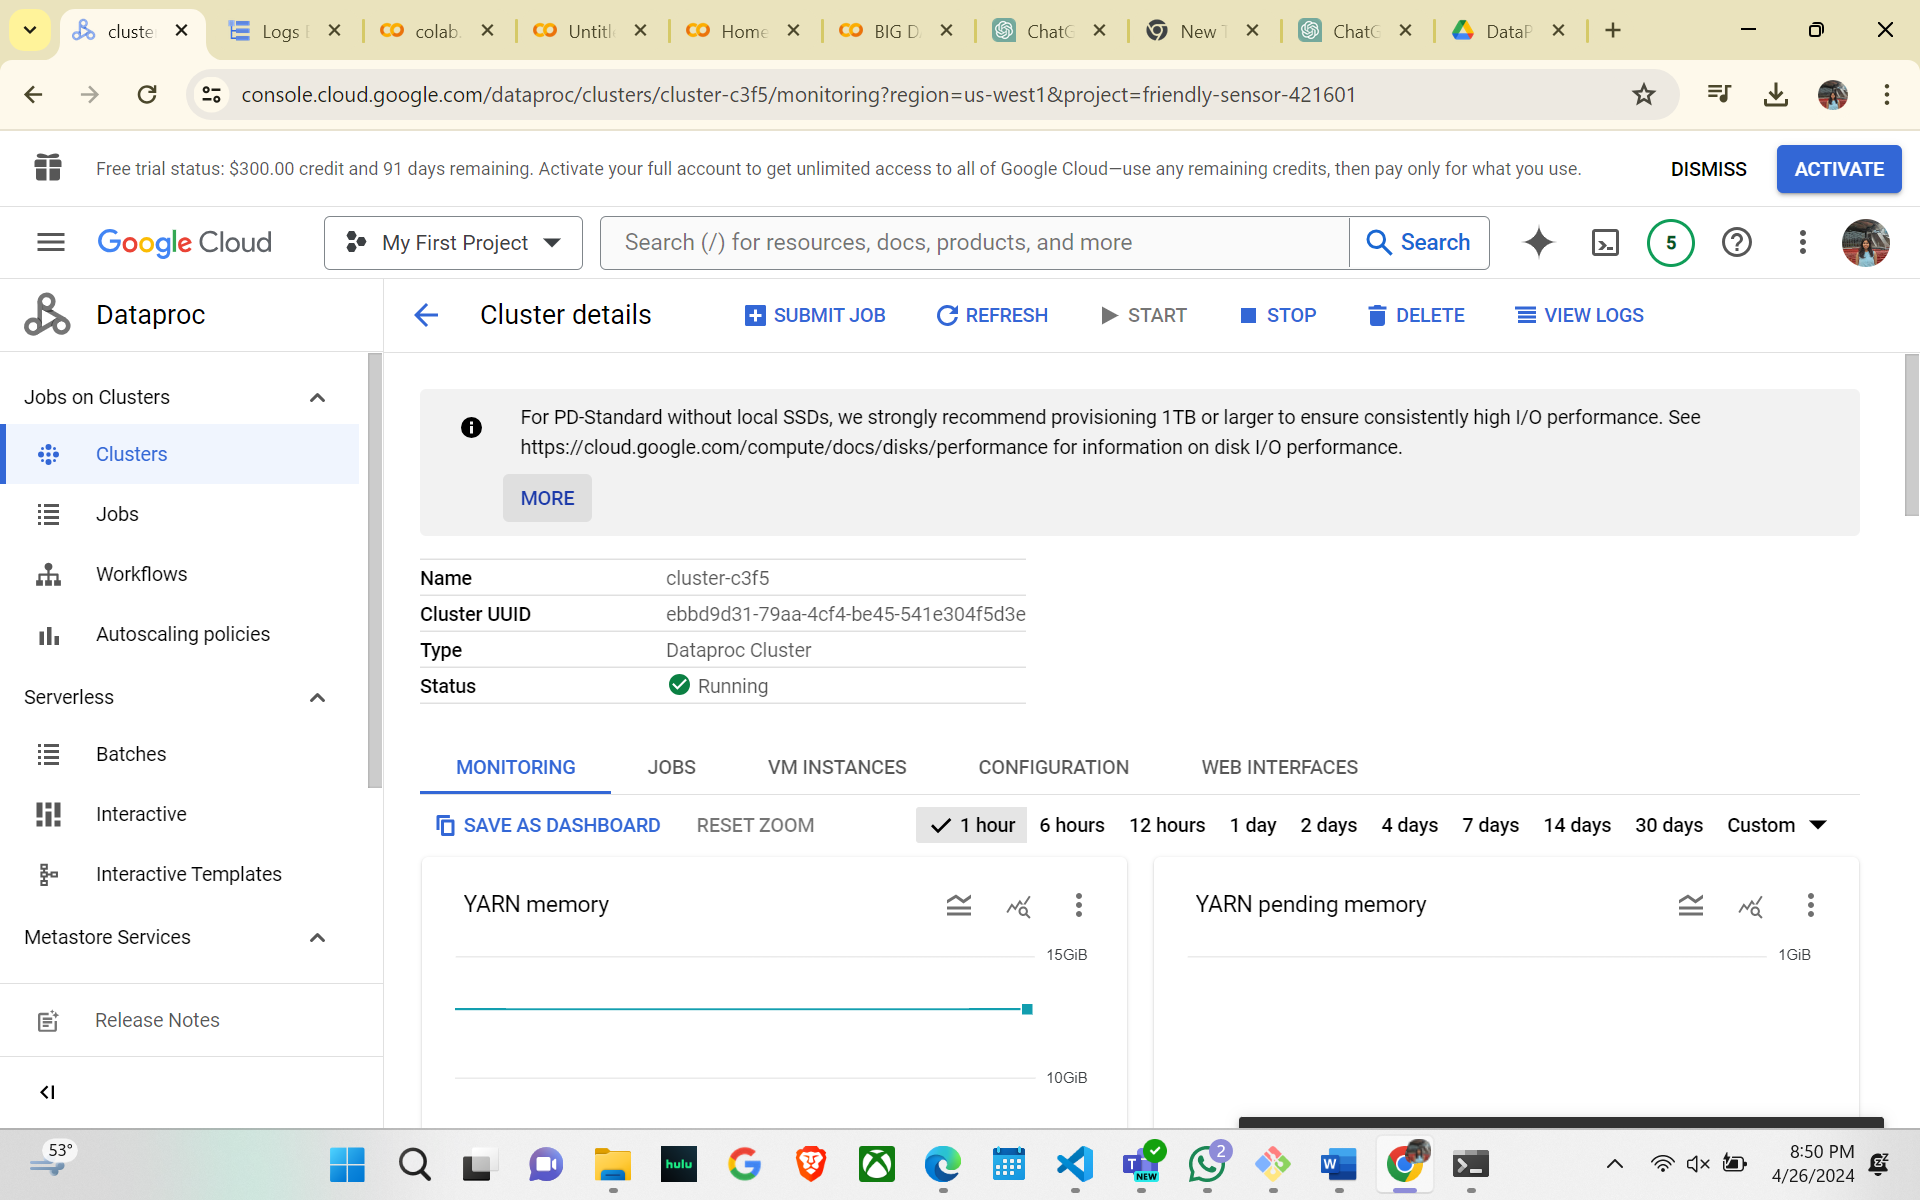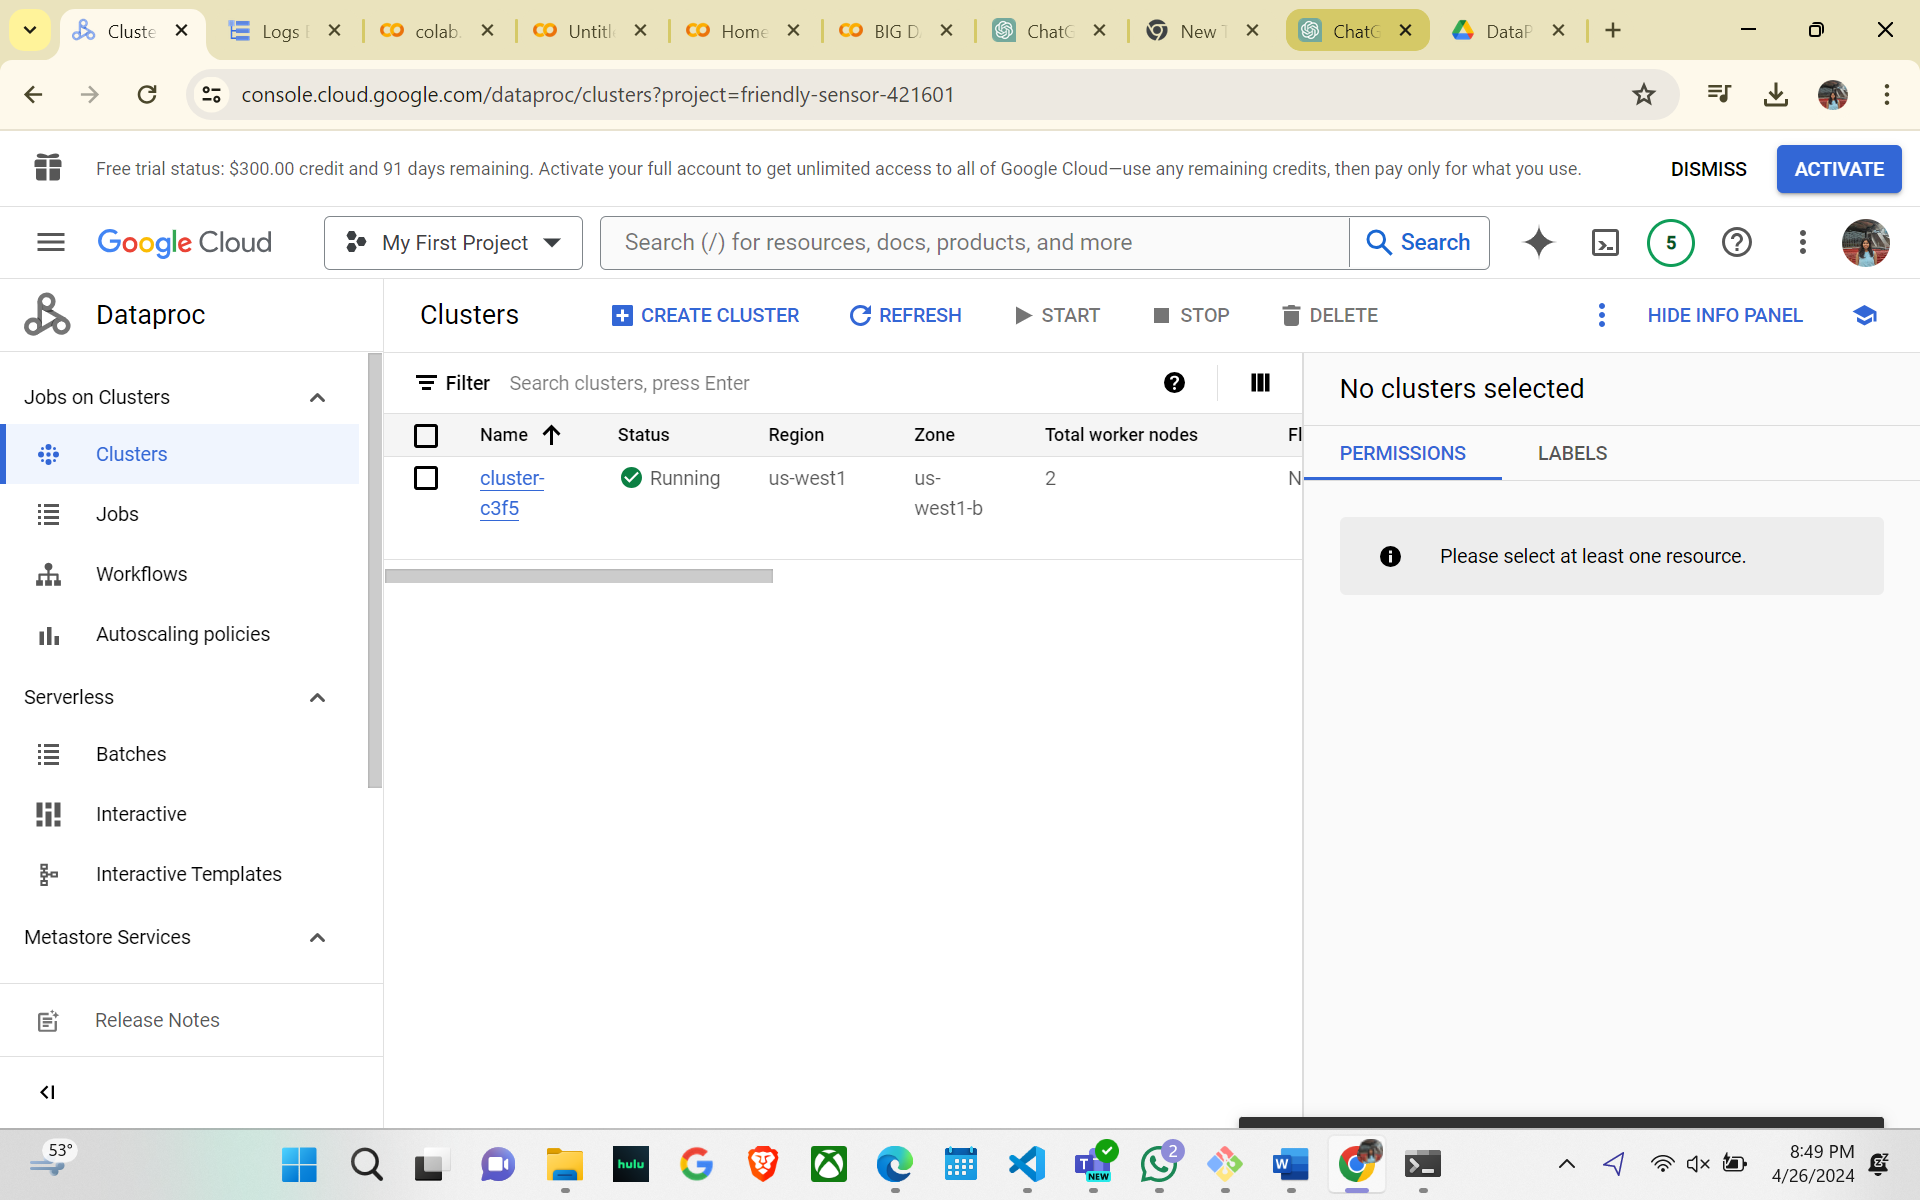

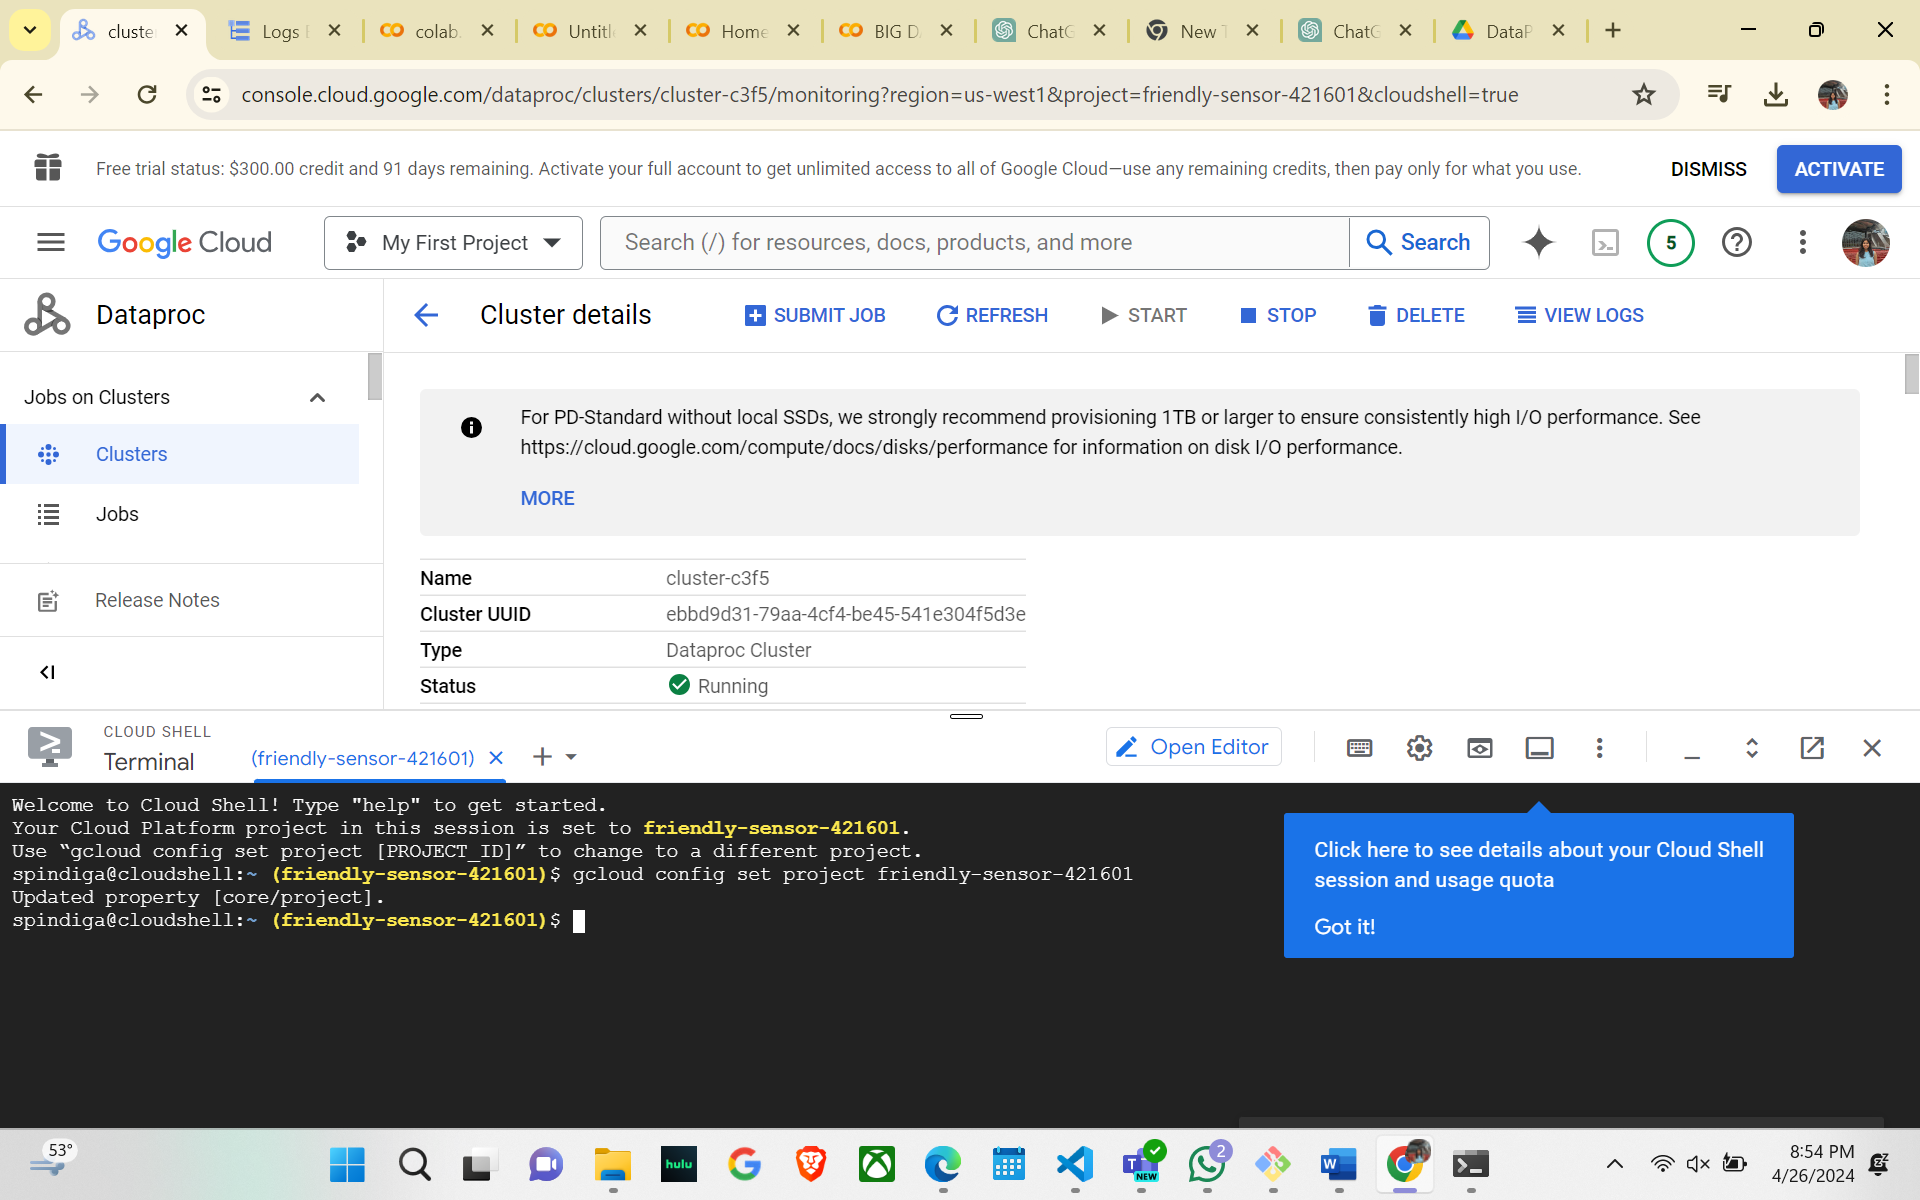